In [1]:
import tensorflow as tf
import keras

from tensorflow.keras import layers
import numpy as np


Using TensorFlow backend.


In [0]:
# ensure consistency across runs
from numpy.random import seed
seed(2)
tf.random.set_seed(2)

# Dataset

In [3]:
#install dependencies
!pip install kaggle

In [4]:
#upload kaggle account credentials
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bobyuwono","key":"9926919560abed66245d90b2cd8e67ec"}'}

In [5]:
# the kaggle API client expects this file to be in ~/.kaggle
!mkdir -p ~/.kaggle
!cp  kaggle.json ~/.kaggle/

# this permission change avoids a warning on kaggle tool startup
!chmod 600 ~/.kaggle/kaggle.json

#import dataset
!kaggle datasets download -d grassknoted/asl-alphabet

!ls

 98% 1.01G/1.03G [00:18<00:00, 54.3MB/s]
100% 1.03G/1.03G [00:18<00:00, 58.1MB/s]
asl-alphabet.zip  kaggle.json  sample_data


In [6]:
import os
!unzip asl-alphabet.zip

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing191.jpg  
  inflating: asl_alphabet_t

Samples images for letter B


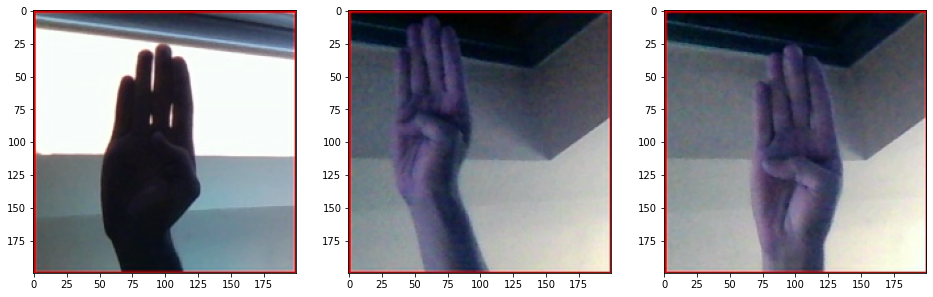

In [7]:
# Imports to view data
import cv2
from glob import glob
from matplotlib import pyplot as plt
from numpy import floor
import random

def plot_three_samples(letter):
    print("Samples images for letter " + letter)
    base_path = 'asl_alphabet_train/asl_alphabet_train/'
    img_path = base_path + letter + '/**'
    path_contents = glob(img_path)
    
    plt.figure(figsize=(16,16))
    imgs = random.sample(path_contents, 3)
    plt.subplot(131)
    plt.imshow(cv2.imread(imgs[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(imgs[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(imgs[2]))
    return

plot_three_samples("B")

In [8]:
from keras.preprocessing.image import ImageDataGenerator

data_dir = "asl_alphabet_train/asl_alphabet_train"
target_size = (64, 64)
target_dims = (64, 64, 3) # add channel for RGB
n_classes = 29
val_frac = 0.1
batch_size = 64

data_augmentor = ImageDataGenerator(samplewise_center=True, 
                                    samplewise_std_normalization=True, 
                                    validation_split=val_frac)

train_generator = data_augmentor.flow_from_directory(data_dir, target_size=target_size, batch_size=batch_size, shuffle=True, subset="training")
val_generator = data_augmentor.flow_from_directory(data_dir, target_size=target_size, batch_size=batch_size, subset="validation")

Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


In [0]:
cls_train = train_generator.classes

In [30]:
class_names = list(train_generator.class_indices.keys())
class_names

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

In [32]:
print(cls_train)

[ 0  0  0 ... 28 28 28]


In [9]:
from keras.layers import Conv2D, Dense, Dropout, Flatten
from keras.models import Sequential

my_model = Sequential()
my_model.add(Conv2D(64, kernel_size=4, strides=1, activation='relu', input_shape=target_dims))
my_model.add(Conv2D(64, kernel_size=4, strides=2, activation='relu'))
my_model.add(Dropout(0.5))
my_model.add(Conv2D(128, kernel_size=4, strides=1, activation='relu'))
my_model.add(Conv2D(128, kernel_size=4, strides=2, activation='relu'))
my_model.add(Dropout(0.5))
my_model.add(Conv2D(256, kernel_size=4, strides=1, activation='relu'))
my_model.add(Conv2D(256, kernel_size=4, strides=2, activation='relu'))
my_model.add(Flatten())
my_model.add(Dropout(0.5))
my_model.add(Dense(512, activation='relu'))
my_model.add(Dense(n_classes, activation='softmax'))

my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 61, 61, 64)        3136      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        65600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 128)       131200    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 128)       262272    
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 9, 256)        

In [0]:
my_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

In [11]:
my_model.fit_generator(train_generator, epochs=5, validation_data=val_generator)


Epoch 1/5
1224/1224 [==============================] - 111s 91ms/step - loss: 1.3009 - accuracy: 0.5908 - val_loss: 0.6220 - val_accuracy: 0.7844
Epoch 2/5
1224/1224 [==============================] - 104s 85ms/step - loss: 0.2828 - accuracy: 0.9039 - val_loss: 0.4548 - val_accuracy: 0.8399
Epoch 3/5
1224/1224 [==============================] - 104s 85ms/step - loss: 0.1787 - accuracy: 0.9404 - val_loss: 0.3572 - val_accuracy: 0.8562
Epoch 4/5
1224/1224 [==============================] - 104s 85ms/step - loss: 0.1368 - accuracy: 0.9555 - val_loss: 0.3560 - val_accuracy: 0.8772
Epoch 5/5
1224/1224 [==============================] - 104s 85ms/step - loss: 0.1224 - accuracy: 0.9607 - val_loss: 0.5852 - val_accuracy: 0.8845


In [26]:
# upload image to be predicted
from google.colab import files
files.upload()

Saving J_test.jpg to J_test.jpg
Saving T_test.jpg to T_test.jpg


{'J_test.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x00\xc8\x00\xc8\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x

In [0]:
#helper function to predict
import matplotlib.pyplot as plt
import PIL
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

def predict(image_path):
    # Load and resize the image using PIL.
    img = PIL.Image.open(image_path)
    img_resized = img.resize(target_size, PIL.Image.LANCZOS)

    # Plot the image.
    plt.imshow(img_resized)
    plt.show()

    # Convert the PIL image to a numpy-array with the proper shape.
    img_array = np.expand_dims(np.array(img_resized), axis=0)

    # Use the VGG16 model to make a prediction.
    # This outputs an array with 1000 numbers corresponding to
    # the classes of the ImageNet-dataset.
    pred = my_model.predict(img_array)
    print(pred)
    # Decode the output of the VGG16 model.
    # pred_decoded = decode_predictions(pred)[0]

    # # Print the predictions.
    # for code, name, score in pred_decoded:
    #     print("{0:>6.2%} : {1}".format(score, name))

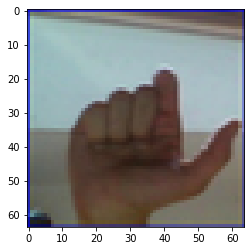

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]]


In [28]:
predict(image_path='T_test.jpg')